# Analyse relation of input parameters to predicted dmg by RF


In [3]:
import os
import rioxarray as rioxr
import xarray as xr
import cftime

import re
import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd 

import seaborn as sns

# Import user functions
import nbFunctions as myf

homedir = '/Users/.../Documents'


path2savefig = os.path.join(homedir,'Data/NERD/plots_dev/predictor_plots')


In [4]:

# plt.rcParams.update({'font.size': 16})
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




[(0.46364792, 0.71617961, 0.56674986),
 (0.31270304, 0.62072111, 0.56379321),
 (0.20094292, 0.52087429, 0.55342884),
 (0.11409965, 0.42169502, 0.54065622),
 (0.13865499, 0.30988598, 0.50636017)]

[(0.10120483036935347, 0.08028952282539623, 0.18460915180334375),
 (0.08605633600581405, 0.23824692404212, 0.30561236308077167),
 (0.11789134778719829, 0.39694259707734425, 0.2588678372388254),
 (0.3292772926340829, 0.4762845556584382, 0.1837155549758328),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.812420762188067, 0.6167295569758052, 0.8578575836301946),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403),
 (0.826811144552662, 0.9338331128274076, 0.9359622361392606)]

Palette-long


[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.50711872, 0.73665492, 0.56821764),
 (0.37890483, 0.66859548, 0.56566462),
 (0.28251558, 0.59517119, 0.56181204),
 (0.20094292, 0.52087429, 0.55342884),
 (0.12709242, 0.44601517, 0.54438795),
 (0.11646936, 0.36578429, 0.52726234),
 (0.15138673, 0.27982444, 0.49119848)]

Palette-long: temporal_pallete 1997+crest :  ['#fa8072', '#81bc91', '#61aa90', '#48988f', '#33858d', '#20728b', '#1e5d86', '#27477d']


## Load RF

In [5]:
import joblib 
# cwdir = os.path.abspath('../')
path2predictor = '../files' # os.path.join(cwdir,'files/')

## Downsampled 20x20, dres=pct095
model_name = 'RF_gridSearch_bestEstimator.joblib' #'RF_gridSearch_2023-07-10T12:47_bestEstimator_AIS_res20x20_dmg053_outerGroupFold3.joblib'
configFile = 'RF_gridSearch.ini' #'RF_gridSearch_train-RF-69571_2023-07-10T12/47..ini' 
iceshelves_testset = ['Shackleton' ,'Amery', 'Rennick' ,'Stange', 'Ross_East', 'Publications',
 'Pine_Island' ,'Bach' ,'Dibble', 'Withrow' ,'Abbot_3' ,'Moubray', 'Mendelssohn',
 'Whittle', 'Wordie_(Prospect)' ,'Deakin', 'Sandford', 'Wordie_(Harriott)']  # names based on MEASURES dataset
# predictor_name = model_name.split('_bestEstimator_')[0] + '_res20x20'
search_section = 'GRIDSEARCH'
space_section = 'GRIDSEARCHSPACE'


loaded_rf = joblib.load(os.path.join(path2predictor,model_name))

feature_list = list(loaded_rf.feature_names_in_)
feature_list

['emax_1px',
 'e_eff_1px',
 'eshear_1px',
 'elon_1px',
 'etrans_1px',
 'v',
 'dEmax_1px',
 'deltaV',
 'rema']

## Load observational data used for RF training  

In [9]:
## Read observational data 
filename = 'data_RFinput_pxs_AIS_20x20_2015-2018.csv'
data_pxs_df = pd.read_csv(os.path.join(homedir, 'Data/NERD/data_predictor/csv/pxs_clipped_to_ishelf/', filename) ) 
data_pxs_df


,vx,vy,rema,v,emax_1px,emin_1px,e_eff_1px,elon_1px,etrans_1px,eshear_1px,dEmax_1px,deltaV
0,-31.944979,-122.244650,8.437870,126.349660,0.003979,-0.002104,0.003448,0.003871,-0.001997,-0.000801,-0.000925,12.908997
1,-41.898705,-95.201866,15.284325,104.013920,0.004529,-0.001939,0.003936,0.004526,-0.001936,-0.000132,0.002665,-7.436119
2,-57.402245,-77.018790,14.671486,96.056816,0.003278,-0.001975,0.002858,0.003094,-0.001792,0.000963,0.001632,-21.009315
3,-71.124300,-67.229940,14.440417,97.869970,0.001429,-0.001085,0.001292,0.000800,-0.000456,0.001089,0.000179,-19.424873
4,-84.266640,-66.272080,15.151482,107.204735,0.000675,-0.003074,0.002799,-0.002805,0.000405,0.000969,-0.002491,-3.762596
...,...,...,...,...,...,...,...,...,...,...,...,...
45641,-4.434423,68.392160,0.000000,68.535770,0.002113,-0.000940,0.001834,0.001687,-0.000513,-0.001059,0.000692,48.967278
45642,-9.233008,85.163490,0.000000,85.662530,0.003002,-0.001192,0.002619,0.001699,0.000112,-0.001941,0.001280,39.405464
45643,-25.300280,100.669975,0.000000,103.800520,0.002144,-0.001829,0.002005,0.001310,-0.000995,-0.001618,0.000783,57.233932
45644,-54.521190,115.524640,0.000000,127.743900,0.001888,-0.003620,0.003136,0.001181,-0.002914,-0.001841,0.000897,135.134340


#### calculate median of all parameters

In [10]:
data_pxs_df['elon_1px'].median() # 0.00156
data_pxs_df['elon_1px'].abs().median() # 0.0020

data_pxs_df

data_median = data_pxs_df.abs().median().to_dict()
data_median


{'vx': 129.97012999999998,
 'vy': 191.605895,
 'rema': 2.290717,
 'v': 324.952455,
 'emax_1px': 0.0028095461,
 'emin_1px': 0.0016961846499999999,
 'e_eff_1px': 0.0032303205,
 'elon_1px': 0.0020079824,
 'etrans_1px': 0.00117910235,
 'eshear_1px': 0.00121308195,
 'dEmax_1px': 0.0007801855,
 'deltaV': 19.8271485}

In [ ]:
# data_ranges_pct = {
#     'vx':[-615.1,354.6],
#     'vy':[-845.5,964.0],
#     'rema':[0.0,90.9],
#     'v':[29.5,1166.2],
#     'emax_1px':[0.000235,0.019706],
#     'emin_1px':[-0.015838,0.001014],
#     'e_eff_1px':[0.000765,0.021605],
#     'elon_1px':[-0.004688,0.011001],
#     'etrans_1px':[-0.005915,0.004312],
#     'eshear_1px':[-0.007810,0.007770],
#     'dEmax_1px':[-0.000962,0.007326],
#     'deltaV':[-7.1,865.5],
# }
data_ranges_pct = { ## manually adjusted for nice ranges.
    'rema':[0,100],
    'v':[0,1150],
    'emax_1px':[0.0002,0.0200],
    'emin_1px':[-0.0160,0.0010],
    'e_eff_1px':[0.0005,0.0215],
    'elon_1px':[-0.0050,0.0110],
    'etrans_1px':[-0.0060,0.0060],
    'eshear_1px':[-0.0075,0.0075],
    'dEmax_1px':[-0.0010,0.0075],
    'deltaV':[-5,865],
}

data_std = {
    'rema':[36.672546],
    'v':[433.081543],
    'emax_1px':[0.011818],
    'emin_1px':[0.011343],
    'e_eff_1px':[0.012975],
    'elon_1px':[0.010044],
    'etrans_1px':[0.006184],
    'eshear_1px':[0.009245],
    'dEmax_1px':[0.005072],
    'deltaV':[264.120117]
}


In [11]:
## roma/batlow colors:
hex_pink = '#F3CEF7'
hex_orange='#C89651'
hex_green='#486B57'
hex_blue='#061855'
batlow_palette = sns.color_palette([hex_pink,hex_orange,hex_green,hex_blue])
# batlow_palette = sns.color_palette(['#3b0f70'])
batlow_palette

[(0.9529411764705882, 0.807843137254902, 0.9686274509803922),
 (0.7843137254901961, 0.5882352941176471, 0.3176470588235294),
 (0.2823529411764706, 0.4196078431372549, 0.3411764705882353),
 (0.023529411764705882, 0.09411764705882353, 0.3333333333333333)]

In [12]:
feature_list_plotOrder = ['rema','v','deltaV','e_eff_1px','emax_1px','dEmax_1px','elon_1px','eshear_1px','etrans_1px']

label_names = {'emax_1px':'principal strain',
 'e_eff_1px':'effective strain',
 'eshear_1px':'shear strain',
 'elon_1px':'longit. strain',
 'etrans_1px':'transverse strain',
 'v':'velocity',
 'dEmax_1px':'strain change',
 'deltaV':'velocity change',
 'rema':'height'}


## Create plot: increase one variable between 5-95 pct, keep other variables at their median value + Gaussian noise (small variation around each variables median value)

RFpred_scatterplot_noisydata_150-x-samples_5noiseSamples-per-x_0.05medLimit4noise_50rolling_ELonWithNoise_abs.png


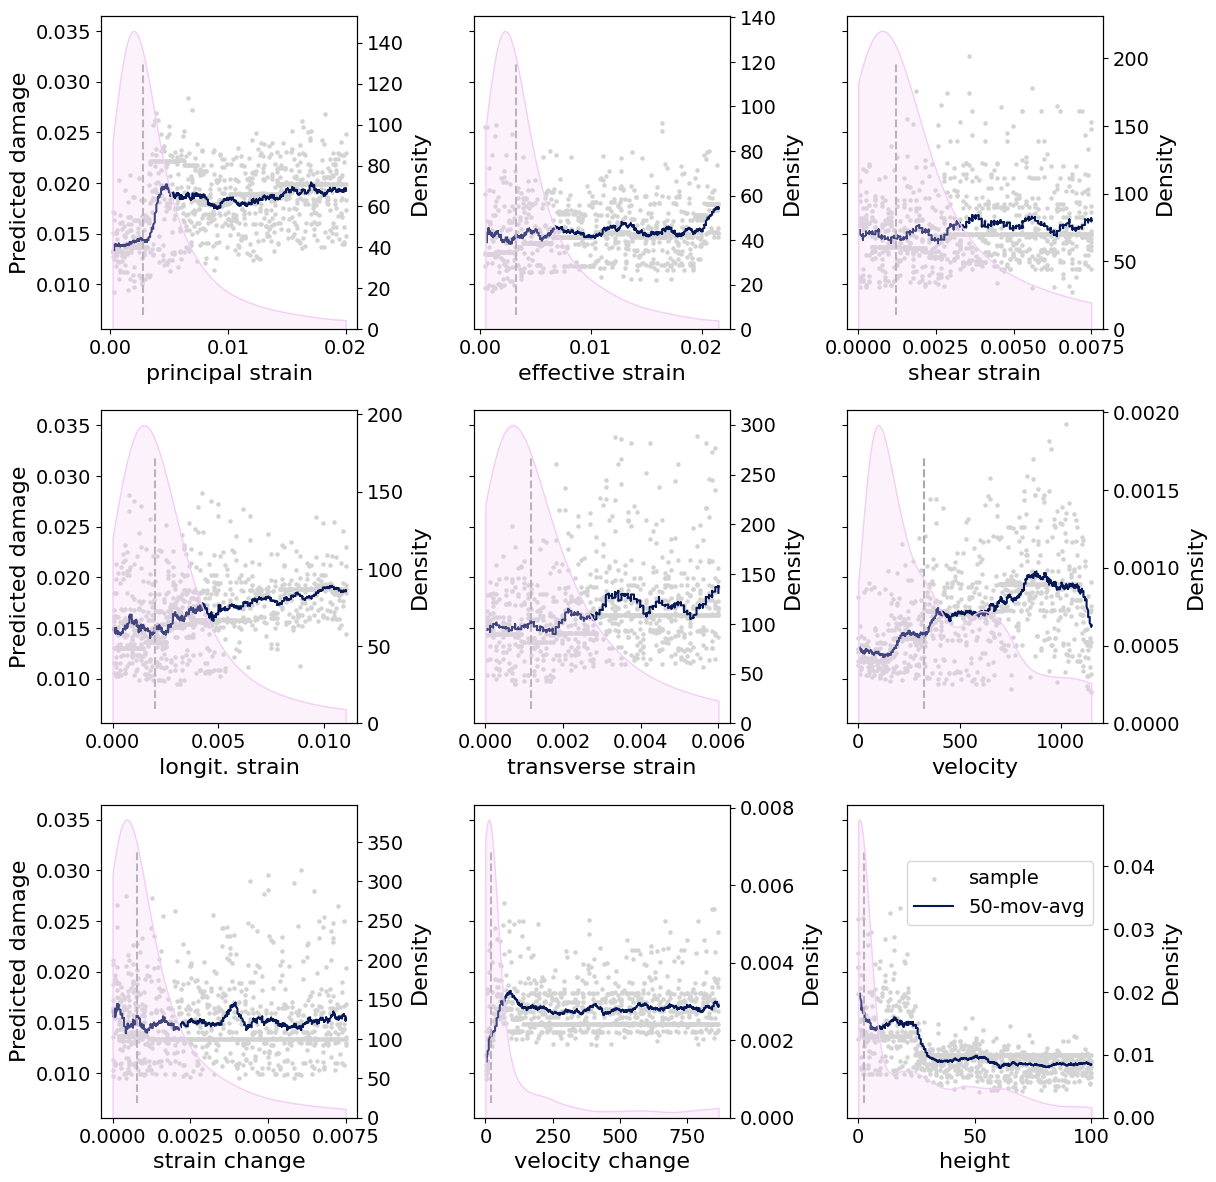

In [13]:
from sklearn.linear_model import LinearRegression

fig,axs=plt.subplots(3,3,figsize=(12,12),sharey=True); 
r=0;c=0
## add noise pertubations
n_samples=750
n_samples=150

data_abs = True

param_uncertainty = dict()
for i, varname1 in enumerate(feature_list): # _plotOrder):
    ''' -------------------
    ## NO NOISE REALISATION; 1 variable parameter and all others constant
    # -------------------'''


    ''' define which parameter to make variable, and keep all others constant '''
    x1 = np.linspace(data_ranges_pct[varname1][0],data_ranges_pct[varname1][1],num=n_samples) 
    # # make strain variables absolute
    if data_abs: x1 = np.abs(x1)
    
    ''' cnst parameters'''
    cnst_vars= [x for x in feature_list if x != varname1]
    # print(cnst_vars)
    # Convert the dictionary to a DataFrame
    df_cnst = pd.DataFrame(data_median, index=[0])
    df_cnst = pd.concat([df_cnst] * n_samples, ignore_index=True) # repeat 1 value for every x_i

    ''' Make 1 dataframe '''
    df_input = df_cnst[cnst_vars].copy()
    df_input.insert(0,column=varname1,value=x1)
    df_input['noiseIter'] = 0

    ''' -------------------
    ## Add noise samples to every x_i
    # -------------------'''
    n_noise = 5
    for noise_realisation_i in range(1,n_noise+1): # make three noise samples per x
        ### EACH NOISE REALISATION

        ''' define which parameter to make variable, and keep all others constant '''
        xlim = data_ranges_pct[varname1]
        x1 = np.linspace(xlim[0],xlim[1],num=n_samples) #
        # # make strain variables absolute
        if data_abs: x1 = np.abs(x1) # all absolute

        ''' make cnst variables with gaussian noise ''' 
        X_input = x1.reshape(n_samples,1)
        ds = 0.1 # limit range of standard devation to limit noise strength
        ds = 0.05 ## FOR PLOT v0and v1
        # ds=0.01

        for cvar in cnst_vars:
            # noise = np.random.normal(0, data_median[cvar]*ds,  # mean & std of noise: std ofnoise is small value around median
            #             size=(x1.shape[0], 1), 
            #             )
            noise = np.random.normal(0, data_pxs_df.abs().std()[cvar]*ds,  # mean & std of noise: std of noise is small percentage of data-std
                        size=(x1.shape[0], 1), 
                        )
                       
            Xi = np.ones((x1.shape[0], 1)) * data_median[cvar] + noise

            # make strain variables absolute
            if data_abs: Xi = np.abs(Xi)


            if np.min(Xi) < 0:
                print( cvar,  np.min(Xi))

            # add to dataframe
            X_input = np.concatenate([X_input, Xi], axis=1)
        

        '''Create a DataFrame with the noisy data'''
        columns = [varname1] + cnst_vars
        df_input_noise = pd.DataFrame(X_input, columns=columns)
        df_input_noise['noiseIter'] = noise_realisation_i

        ''' Append dataframe with noisy data'''
        df_input = pd.concat([df_input,df_input_noise])

    ''' -------------------
    ##  make prediction
    -----------------------'''

    y_rf_pred = loaded_rf.predict(  df_input[feature_list] )  # # input in correct order for RF
    df_input['dmg_pred'] = y_rf_pred
    df_input['noiseIter'] = df_input['noiseIter'].astype("category")

    ''' also calculate running mean '''
    df = pd.DataFrame({'x': df_input[varname1], 'y': y_rf_pred})
    df.sort_values(by='x', inplace=True)
    wsize = 50 #30
    df['y_mean'] = df['y'].rolling(wsize, min_periods=10).mean()
    df['y_std'] = df['y'].rolling(wsize, min_periods=10).std() # .quantile(0.25) 
    df['y_low']= df['y_mean'] - df['y_std'] # lower bound 
    df['y_up']= df['y_mean'] + df['y_std'] # upper bound 

    shaded_range = df['y_up'] - df['y_low'] # difference between shaded area
    
    param_uncertainty[varname1]=shaded_range.mean()

    ''' -------------------
    ## PLOT
    -----------------------'''
    ax=axs[r,c]

    '''## add data pdf '''
    ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
    if data_abs: 
        kde = sns.kdeplot(ax=ax2, data=data_pxs_df.abs(), x=varname1, 
                    common_norm=True,
                    cut=0,# dont make kde outside of paaram minmaax
                    clip=xlim , # clip plot to x range
                    color=hex_pink,
                    fill=True,
                    label='observations',
                    )
    else:
        kde = sns.kdeplot(ax=ax2, data=data_pxs_df, x=varname1, 
                    common_norm=True,
                    cut=0,# dont make kde outside of paaram minmaax
                    clip=xlim , # clip plot to x range
                    color=hex_pink,
                    fill=True,
                    label='observations',
                    )

    '''## add scatter & mov avg'''
    ## add scatter ini 1 color
    ax.scatter(df_input[varname1],y_rf_pred, s=5, color='lightgray', # hex_orange,
        label='sample',
    )    

    '''# add lin fit / mov avg'''
    ax.plot(df.x, df.y_mean,color=hex_blue, 
                label=f'{wsize}-mov-avg')
    # ax.fill_between(df.x, df.y_low, df.y_up, alpha=0.2, color=hex_blue)

    # ## add vertical line at x=0
    # ylim = [0.007,0.032]
    # ymin, ymax = ylim # ax.get_ylim()
    # ax.vlines(0,ymin,ymax, color='darkgrey',linestyle= '--',)

    '''## add vertical line at observational median'''
    ylim = [0.007,0.032]
    ymin, ymax = ylim # ax.get_ylim()
    ax.vlines(data_median[varname1] ,ymin,ymax, color='darkgrey',linestyle= '--',)
    # print(f'cvar: {varname1}, median: {data_median[varname1]}')


    # ''' add range of noise '''
    # min_noise = data_median[varname1] -  data_median[varname1]*ds
    # max_noise = data_median[varname1] +  data_median[varname1]*ds
    # ax.plot([min_noise,max_noise], [ymax*0.8,ymax*0.8], color='black',)

    '''misc '''
    ax.set_xlabel(label_names[varname1])

    
    c+=1
    if c==3:
        r+=1; c=0
fig.tight_layout()
[ax.set_ylabel('Predicted damage') for ax in axs[:,0] ];
# ax.set_ylim([0.007,0.032])
axs[-1,-1].legend(loc='upper right',bbox_to_anchor=(1.0,0.85))

''' save figure '''
# figname=f'RFpred_scatterplot_noisydata_{n_samples}-x-samples_{n_noise}noiseSamples-per-x_{ds}medLimit4noise_{wsize}rolling_ELonWithNoise_abs.pdf'
figname=f'RFpred_scatterplot_noisydata_{n_samples}-x-samples_{n_noise}noiseSamples-per-x_{ds}medLimit4noise_{wsize}rolling_ELonWithNoise_abs.png'
print(figname)
# fig.savefig(os.path.join(path2savefig,'correlation_plots',figname), bbox_inches='tight')
